In [1]:
import numpy as np
import sympy as sy
from IPython.display import display
from matplotlib import pyplot as plt
from itertools import product
import pickle
import sys

#### Define functions and sympy variables

In [2]:
def spherical_to_cartesian(ang_coord_sample):
    cart_vec = []
    for i in range(len(cart_coords)):
        if i == 0:
            cart_coord = -np.cos(ang_coord_sample[i])
        elif i < (len(cart_coords) - 1):
            cart_coord = -np.cos(ang_coord_sample[i])
            for j in range(i):
                cart_coord = np.sin(ang_coord_sample[j]) * cart_coord
        else:
            cart_coord = -np.sin(ang_coord_sample[i-1])
            for j in range(i-1):
                cart_coord = np.sin(ang_coord_sample[j]) * cart_coord
        if abs(0.0 - cart_coord) < np.finfo(np.float64).eps:
            cart_coord = 0.0
        cart_vec.append(cart_coord)
    return cart_vec

def plot_surface(dims, ax_lims=[-5,5], interactive=False, cond='wav', inv_axis=[False,False,False]):
    if interactive:
        %matplotlib widget
    fig = plt.figure(figsize=(6,6))
    if dims == 2:
        ax = fig.add_subplot()
        ax.scatter(J_sub_k[0], J_sub_k[1], c='black')
    else:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(J_sub_k[0], J_sub_k[1], J_sub_k[2], c='black')
    x_lams = []
    for i in range(len(C_k)):
        params = [C_k[i], J_k[i], kappa]
        expr = -C_k[i]*kappa + J_k[i]
        x_lam = sy.lambdify(params, expr, 'numpy')
        x_lams.append(x_lam)
    for i in range(len(data[sy.sstr(C_k[0])])):
        if cond == 'wav':
            condition = np.isnan(data['kappa_cs']['wav'][i]) == False
            kappa_cs = np.extract(condition, data['kappa_cs']['wav'][i])
            color = 'red'
        else:
            condition = np.isnan(data['kappa_cs']['st'][i]) == False
            kappa_cs = np.extract(condition, data['kappa_cs']['st'][i]) 
            color = 'blue'
        for kappa_c in kappa_cs:
            coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j]), kappa_c) for j, x_lam in enumerate(x_lams)]
            ax.scatter(*zip(coords), c=color)
    ax.set_xlim(ax_lims[0],ax_lims[1])
    ax.set_ylim(ax_lims[0],ax_lims[1])
    if dims > 2: ax.set_zlim(ax_lims[0],ax_lims[1])
    ax.set_xlabel(M_sub_k[0])
    ax.set_ylabel(M_sub_k[1])
    if dims > 2: ax.set_zlabel(M_sub_k[2])
    if inv_axis[0]: ax.invert_xaxis()
    if inv_axis[1]: ax.invert_yaxis()
    if dims > 2:
        if inv_axis[2]:
            ax.invert_zaxis()

def store_sample(cond, kappa_arr):
    if cond == 'wav':
        kappa_arr = kappa_wavs
    else:
        kappa_arr = kappa_sts
    kappa_c_dir = []
    for kappa_c in kappa_arr:
        if np.isreal(kappa_c) and (kappa_c > 0):
            kappa_c_dir.append(kappa_c)
        else:
            kappa_c_dir.append(np.nan)
    if verbose: print('kappa_c_dir', kappa_c_dir)
    # Store critical kappas
    if cond == 'wav':
        data['kappa_cs']['wav'].append(kappa_c_dir)
    else:
        data['kappa_cs']['st'].append(kappa_c_dir)

# Define sympy symbols
u, w, v = sy.symbols("u w v")
r_u, r_v, K_u, K_v, A_uv, A_uw, A_vw, B_uv, B_uw, B_vw = sy.symbols('r_u, r_v, K_u, K_v, A_uv, A_uw, A_vw, B_uv, B_uw, B_vw')
d_v, d_w, e_uv, e_uw, e_vw = sy.symbols('d_v, d_w, e_uv, e_uw, e_vw')
kappa, lamda = sy.symbols('kappa lamda')
D_u, D_v, D_w = sy.symbols('D_u D_v D_w')
J11, J12, J13, J21, J22, J23, J31, J32, J33 = sy.symbols('J11 J12 J13 J21 J22 J23 J31 J32 J33')
C11, C12, C13, C21, C22, C23, C31, C32, C33 = sy.symbols('C11 C12 C13 C21 C22 C23 C31 C32 C33')

# Single parameterization

#### Define model (i.e. J and C) and conditions

In [11]:
model_params = [r_u, r_v, K_u, K_v, A_uv, A_uw, A_vw, B_uv, B_uw, B_vw, d_v, d_w, e_uv, e_uw, e_vw]
modules = ['chain', 'apparent', 'exploitative', 'omnivory']
ev_checks = np.full(len(modules), False)
attempts = 0
while not np.all(ev_checks):
    attempts += 1
    # param_vals = [(r_u, 3.0), (K_u, 3.0), (A_uv, 1.0), (A_vw, 1.0), (B_uv, 0.25), (B_vw, 0.25)]
    param_vals = []
    cond = [p not in param_vals for p in model_params]
    for param in np.extract(cond, model_params):
        param_vals.append((param, 10.0 * np.random.sample()))
    # x0 = (1, 2.5, 10.2)
    # x0 = (2.5, 2.5, 2.5)
    # scales = np.array([10,10,10])
    # scales = np.array([2,3,8])
    x0_trials = 10
    for i in range(x0_trials):
        # x0s = np.zeros(3)
        steady_states = np.zeros((len(modules), 3))
        module_evs = np.zeros((len(modules), 3))
        ev_checks = np.full(len(modules), False)
        # scales = np.random.randint(1,10, (3))
        # scales = np.array([np.random.randint(2,4),
        #                    np.random.randint(4,6),
        #                    np.random.randint(6,8)])
        scales = np.ones(3) * 8
        x0 = np.random.random(3) * scales
        # x0s[i] = x0
        for module_i, module in enumerate(modules):
            # Define nonlinear interaction terms
            'G_i -> prey growth, R_ij -> functional response, F_ij -> predation gains'
            G_u = r_u*(1 - u/K_u)
            G_v = r_v*(1 - v/K_v)
            R_uv = A_uv/(u+B_uv)
            R_uw = A_uw/(u+B_uw)
            R_vw = A_vw/(v+B_vw)
            if module == 'chain':
                f = u * (G_u - v*R_uv)
                g = v * (e_uv*R_uv - v*d_v - w*R_vw)
                h = w * (e_vw*R_vw - w*d_w)
            if module == 'exploitative':
                f = u * (G_u - v*R_uv - w*R_uw)
                g = v * (e_uv*R_uv - v*d_v)
                h = w * (e_uw*R_uw - w*d_w)
            if module == 'apparent':
                f = u * (G_u - w*R_uw)
                g = v * (G_v - w*R_vw)
                h = w * (e_uw*R_uw + e_vw*R_vw - w*d_w)
            if module == 'omnivory':
                f = u * (G_u - v*R_uv - w*R_uw)
                g = v * (e_uv*R_uv - w*R_vw - v*d_v)
                h = w * (e_uw*R_uw + e_vw*R_vw - w*d_w)
            # print('{} module:'.format(module))
            # display(sy.Eq(sy.Symbol('f(u,v,w)'),f),
            #         sy.Eq(sy.Symbol('g(u,v,w)'),g),
            #         sy.Eq(sy.Symbol('h(u,v,w)'),h))
            # print('\n----------------------------------------------------\n'); continue
            # print('\nparameter values:'); display(param_vals)

            # Solve for the uniform steady state
            eq_vec = (sy.Eq(f.subs(param_vals),0), 
                      sy.Eq(g.subs(param_vals),0), 
                      sy.Eq(h.subs(param_vals),0))
            var_vec = (u, v, w)
            try:
                u_0, v_0, w_0 = sy.nsolve(eq_vec, var_vec, x0)
            except:
                ev_checks[module_i] = False
                continue
            steady_state = np.array([u_0, v_0, w_0])
            if not np.all(steady_state > 0.05):
                ev_checks[module_i] = False
                continue
            else:
                steady_states[module_i] = (u_0, v_0, w_0)
                # print('\nsteady state:\nu_0 = {}, v_0 = {}, w_0 = {}\n'.format(u_0, v_0, w_0))

                J = sy.Matrix([[J11, J12, J13], 
                               [J21, J22, J23], 
                               [J31, J32, J33]])
                J_star = sy.Matrix([[sy.diff(f, u), sy.diff(f, v), sy.diff(f, w)],
                               [sy.diff(g, u), sy.diff(g, v), sy.diff(g, w)],
                               [sy.diff(h, u), sy.diff(h, v), sy.diff(h, w)]])
                J_sub = J_star.subs(param_vals + [(u, u_0), (v, v_0), (w, w_0)])

                evs = np.array([complex(val) for val in J_sub.eigenvals()])
                module_evs[module_i] = evs
                # print('\nnonspatial jacobian eigenvalues:\n',evs)#; print('\n----------------------------------------------------\n')
                if np.any(np.real(evs) > 0):
                    ev_checks[module_i] = False
                    continue
                else:
                    ev_checks[module_i] = True
        if np.all(ev_checks):
            break

/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_16389/3232169940.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  module_evs[module_i] = evs


In [12]:
print(attempts)
print(x0)
print(steady_states)
print(module_evs)

4
[7.99254036 6.29497201 1.60851657]
[[1.07123076 1.74291501 0.07511617]
 [1.21394582 2.42924802 0.96204919]
 [0.7673907  1.85486443 0.98795592]
 [0.75168327 1.82496261 1.06557308]]
[[-7.52145497 -3.51309718 -0.39818608]
 [-8.7245662  -8.52130836 -4.55062383]
 [-2.70997488 -4.86741796 -6.63073372]
 [-2.69822365 -4.87501876 -6.83182913]]


In [13]:
param_vals

[(r_u, 9.931167850316495),
 (r_v, 8.81334953554151),
 (K_u, 1.4395206726048215),
 (K_v, 2.448717228521511),
 (A_uv, 7.5113979899715),
 (A_uw, 7.702034347072719),
 (A_vw, 0.4489123862552302),
 (B_uv, 4.081349224131106),
 (B_uw, 3.54739904746882),
 (B_vw, 3.7339810535800764),
 (d_v, 2.394933513998836),
 (d_w, 5.303964216590389),
 (e_uv, 2.867568171464817),
 (e_uw, 2.935569321679318),
 (e_vw, 4.8607911089062945)]

In [10]:
x0

array([7.61163636, 4.72053042, 3.05499621])

In [20]:
modules = ['chain', 'apparent', 'exploitative', 'omnivory']
# module = 'chain'
for module in modules:
# for module in ['omnivory']:
    # Define nonlinear interaction terms
    'G_i -> prey growth, R_ij -> functional response, F_ij -> predation gains'
    G_u = r_u*(1 - u/K_u)
    G_v = r_v*(1 - v/K_v)
    R_uv = A_uv/(u+B_uv)
    R_uw = A_uw/(u+B_uw)
    R_vw = A_vw/(v+B_vw)
    if module == 'chain':
        f = u * (G_u - v*R_uv)
        g = v * (e_uv*R_uv - v*d_v - w*R_vw)
        h = w * (e_vw*R_vw - w*d_w)
    if module == 'exploitative':
        f = u * (G_u - v*R_uv - w*R_uw)
        g = v * (e_uv*R_uv - v*d_v)
        h = w * (e_uw*R_uw - w*d_w)
    if module == 'apparent':
        f = u * (G_u - w*R_uw)
        g = v * (G_v - w*R_vw)
        h = w * (e_uw*R_uw + e_vw*R_vw - w*d_w)
    if module == 'omnivory':
        f = u * (G_u - v*R_uv - w*R_uw)
        g = v * (e_uv*R_uv - w*R_vw - v*d_v)
        h = w * (e_uw*R_uw + e_vw*R_vw - w*d_w)
    print('{} module:'.format(module))
    display(sy.Eq(sy.Symbol('f(u,v,w)'),f),
            sy.Eq(sy.Symbol('g(u,v,w)'),g),
            sy.Eq(sy.Symbol('h(u,v,w)'),h))
    # print('\nparameter values:'); display(param_vals)

    # Solve for the uniform steady state
    eq_vec = (sy.Eq(f.subs(param_vals),0), 
              sy.Eq(g.subs(param_vals),0), 
              sy.Eq(h.subs(param_vals),0))
    var_vec = (u, v, w)
    # for i in range(10):
    #     scales = np.array([np.random.randint(2,4),
    #                        np.random.randint(4,6),
    #                        np.random.randint(6,8)])
    #     x0 = np.random.random(3) * scales
    print('x0:', x0)
    # try:
    u_0, v_0, w_0 = sy.nsolve(eq_vec, var_vec, x0)
    print(u_0, v_0, w_0)
    # except:
    J = sy.Matrix([[J11, J12, J13], 
                   [J21, J22, J23], 
                   [J31, J32, J33]])
    J_star = sy.Matrix([[sy.diff(f, u), sy.diff(f, v), sy.diff(f, w)],
                   [sy.diff(g, u), sy.diff(g, v), sy.diff(g, w)],
                   [sy.diff(h, u), sy.diff(h, v), sy.diff(h, w)]])
    J_sub = J_star.subs(param_vals + [(u, u_0), (v, v_0), (w, w_0)])
    evs = np.array([complex(val) for val in J_sub.eigenvals()])
    print('\nnonspatial evs:', evs)
    # if np.any(np.real(evs) > 0):
    #     print('trying another x0')
    #     continue
    # else:
    C = sy.Matrix([[C11, 0, 0], 
                   [0, C22, 0], 
                   [0, 0, C33]])
    M = J_sub - kappa*C
    M_sub = M
    # print('\nmetacommunity jacobian:'); display(M)
    M_star = sy.zeros(3,3)
    for i,j in product(range(M.shape[0]), repeat=2):
        if C[i,j] != 0:
            M_star[i,j] = -C[i,j]*kappa
        else:
            M_star[i,j] = J_sub[i,j]

    # Characteristic polynomial
    p = M_star.charpoly(lamda)
    p_coeffs = p.all_coeffs()

    # Oscillatory and stationary instability conditions
    I_wav = p_coeffs[3] - p_coeffs[1]*p_coeffs[2]
    I_st = p_coeffs[3]

    # Store spatially dependent elements of C, J, and M
    C_k, M_sub_k, J_k, J_sub_k = ([],[],[],[])
    for i in range(C.shape[0]):
        for j in range(C.shape[0]):
            if C[i,j] != 0:
                C_k.append(C[i,j])
                M_sub_k.append(M_sub[i,j])
                J_k.append(J[i,j])
                J_sub_k.append(J_sub[i,j])
    print('\n----------------------------------------------------\n')
    
    # Constants
    verbose = False
    N_n = 1e3 #Avg density of samples per 0-pi/2 volume
    data = {'kappa_cs': {'wav': [], 'st': []}}
    ang_coords = ['phi_{}'.format(i+1) for i in range(len(C_k)-1)]
    for ang_coord in ang_coords:
        data.update({ang_coord: []})
    cart_coords = [sy.sstr(C_ij) for C_ij in C_k]
    for cart_coord in cart_coords:
        data.update({cart_coord: []})

    # Sample n dimensional dispersal parameter space in (n-1) spherical coordinates
    while len(data[ang_coords[0]]) < (2**len(C_k))*N_n:
        ang_coord_sample = []
        for i, ang_coord in enumerate(ang_coords):
            if i < len(ang_coords) - 1:
                phi_range = (0.0, np.pi)
            else:
                phi_range = (0.0, 2*np.pi)
            phi_sample = phi_range[1] * np.random.sample()
            ang_coord_sample.append(phi_sample)
            if verbose: print('ang_coord_sample', ang_coord_sample)
        # Convert spherical to cartesian coordinates
        cart_coord_sample = spherical_to_cartesian(ang_coord_sample)
        if verbose: print('cart_coord_sample', cart_coord_sample)
        # Store directional data
        for i, coord in enumerate(cart_coord_sample):
            data[cart_coords[i]].append(coord)
        for i, coord in enumerate(ang_coord_sample):
            data[ang_coords[i]].append(coord)
        # Find critical kappa values for this parameterization
        kappa_wavs = []
        kappa_sts = []
        I_wav_sub = I_wav.subs([(C_k[i], cart_coord_sample[i]) for i in range(len(C_k))])
        I_st_sub = I_st.subs([(C_k[i], cart_coord_sample[i]) for i in range(len(C_k))])
        try:
            wav_sols = sy.solveset(I_wav_sub, kappa).args
            st_sols = sy.solveset(I_st_sub, kappa).args
        except:
            print('error at ang_coord_sample {}'.format(ang_coord_sample))
            # wav_sols, st_sols = ([0.0,0.0,0.0], [0.0,0.0,0.0])
            wav_sols, st_sols = ([np.nan,np.nan,np.nan], [np.nan,np.nan,np.nan])
        if verbose: print('sols', wav_sols, st_sols)
        for sol in wav_sols:
            try:
                kappa_wavs.append(float(sol))
            except:
                kappa_wavs.append(complex(sol))
        for sol in st_sols:
            try:
                kappa_sts.append(float(sol))
            except:
                kappa_sts.append(complex(sol))
        store_sample('wav', kappa_wavs)
        store_sample('st', kappa_sts)
        if verbose: print('------------------------------------------------')

    # Make vecs for different conditions (Omega)
    kappa_wavs = data['kappa_cs']['wav']
    kappa_sts = data['kappa_cs']['st']
    Omega_wav, Omega_st, Omega_stab = ([], [], [])
    for i in range(len(kappa_wavs)):
        wav_nonan = [val for val in kappa_wavs[i] if not np.isnan(val)]
        st_nonan = [val for val in kappa_sts[i] if not np.isnan(val)]
        wav = len(wav_nonan) > 0
        st = len(st_nonan) > 0
        if wav and st:
            wav_before_st = min(wav_nonan) < min(st_nonan)
            st_before_wav = min(st_nonan) < min(wav_nonan)
        else:
            wav_before_st = wav
            st_before_wav = st
        Omega_wav.append(wav_before_st)
        Omega_st.append(st_before_wav)
        Omega_stab.append((wav == False) and (st == False))
    # Store data
    for key, vec in zip(['wav', 'st', 'stab'], 
                        [Omega_wav, Omega_st, Omega_stab]):
        data['omega_integrand/'+key] = np.array(vec)

    # Approximate fractional surface areas
    omega_sum = 0.0
    omega_sec_mat = np.zeros((2,4))
    for phi_lims in product(range(2), range(4)):
        conds = []
        for i, lim in enumerate(phi_lims):
            conds.append(np.array(data['phi_'+str(i+1)]) > lim*np.pi/2)
            conds.append(np.array(data['phi_'+str(i+1)]) < (lim + 1)*np.pi/2)
        cond = np.all(conds, axis=0)
        omega_integrand_sec = np.array(data['omega_integrand/wav'])[cond] + np.array(data['omega_integrand/st'])[cond]
        omega_sec = sum(omega_integrand_sec) / sum(cond)
        omega_sec_mat[phi_lims[0], phi_lims[1]] = omega_sec
        omega_sum += sum(omega_integrand_sec)
    omega = omega_sum / len(data['phi_1'])
    data['omega_sec_mat'] = omega_sec_mat
    data['omega'] = omega
    # Write omega data to file
    with open('nocross_data_{}_Nn1e3_Jtest.pkl'.format(module), 'wb') as f:
        pickle.dump(data, f)

chain module:


Eq(f(u,v,w), u*(-A_uv*v/(B_uv + u) + r_u*(1 - u/K_u)))

Eq(g(u,v,w), v*(A_uv*e_uv/(B_uv + u) - A_vw*w/(B_vw + v) - d_v*v))

Eq(h(u,v,w), w*(A_vw*e_vw/(B_vw + v) - d_w*w))

x0: [1.28081606 0.63280683 4.32831638]
1.90614078307395 0.354747407325996 1.24532338912956

nonspatial evs: [-5.23268428+0.j -2.22854673+0.j -3.90989472+0.j]

----------------------------------------------------

apparent module:


Eq(f(u,v,w), u*(-A_uw*w/(B_uw + u) + r_u*(1 - u/K_u)))

Eq(g(u,v,w), v*(-A_vw*w/(B_vw + v) + r_v*(1 - v/K_v)))

Eq(h(u,v,w), w*(A_uw*e_uw/(B_uw + u) + A_vw*e_vw/(B_vw + v) - d_w*w))

x0: [1.28081606 0.63280683 4.32831638]
0.890341090933999 1.09754988064120 3.61163312667758

nonspatial evs: [ -2.03484561+0.j  -1.67031316+0.j -11.46546028+0.j]

----------------------------------------------------

exploitative module:


Eq(f(u,v,w), u*(-A_uv*v/(B_uv + u) - A_uw*w/(B_uw + u) + r_u*(1 - u/K_u)))

Eq(g(u,v,w), v*(A_uv*e_uv/(B_uv + u) - d_v*v))

Eq(h(u,v,w), w*(A_uw*e_uw/(B_uw + u) - d_w*w))

x0: [1.28081606 0.63280683 4.32831638]
1.11897224246956 0.628988546965732 2.40491632872616

nonspatial evs: [-1.92545039+0.j -4.69679974+0.j -7.77648131+0.j]

----------------------------------------------------

omnivory module:


Eq(f(u,v,w), u*(-A_uv*v/(B_uv + u) - A_uw*w/(B_uw + u) + r_u*(1 - u/K_u)))

Eq(g(u,v,w), v*(A_uv*e_uv/(B_uv + u) - A_vw*w/(B_vw + v) - d_v*v))

Eq(h(u,v,w), w*(A_uw*e_uw/(B_uw + u) + A_vw*e_vw/(B_vw + v) - d_w*w))

x0: [1.28081606 0.63280683 4.32831638]
0.710276885255842 0.353117391308408 3.78086813081407

nonspatial evs: [ -1.06103851+0.j  -2.55183894+0.j -11.88517066+0.j]

----------------------------------------------------



#### Plot projection on the unit sphere

In [11]:
'''run this cell to load previously run data'''
with open('nocross_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
'''run this cell to replace with data from cross diffusion run'''
import signac
project = signac.get_project('single_cross_diffusion')
job = project.open_job({'C_offdiag': (1,2), 'J_i': 0, 'N_n': 100.0})
with job.data:
    cond = np.array(job.data['C23']) > 0
    data['kappa_cs']['wav'] = np.array(job.data['kappa_cs']['wav'])[cond]
    data['kappa_cs']['st'] = np.array(job.data['kappa_cs']['st'])[cond]
    data[sy.sstr(C_k[0])] = np.array(job.data['C11'])[cond]
    data[sy.sstr(C_k[1])] = np.array(job.data['C22'])[cond]
    data[sy.sstr(C_k[2])] = np.array(job.data['C33'])[cond]

Text(0.5, 0, '-C33*kappa - 8.78282112318784')

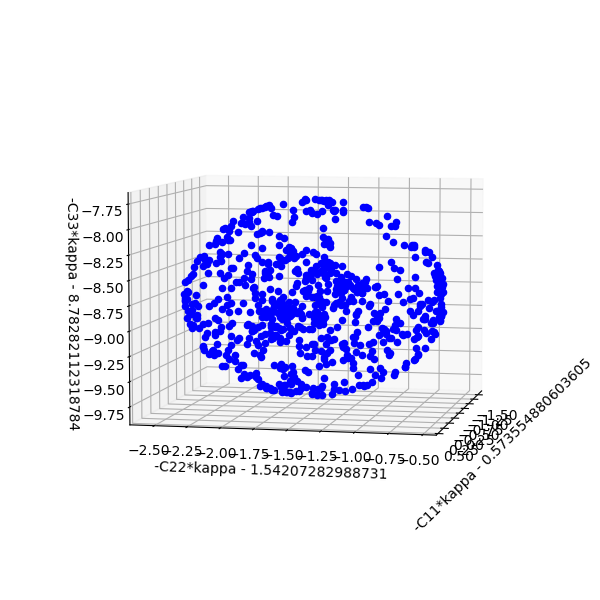

In [29]:
%matplotlib widget
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.view_init(6, 12, 0) #elev, azim, roll
# ax.view_init(49, -77, 0)
# ax.view_init(5, -178, 0)
ax.scatter(J_sub_k[0], J_sub_k[1], J_sub_k[2], c='black')
x_lams = []
for i in range(len(C_k)):
    params = [C_k[i], J_k[i]]
    expr = -C_k[i]*1.0 + J_k[i]
    x_lam = sy.lambdify(params, expr, 'numpy')
    x_lams.append(x_lam)
for i in range(len(data[sy.sstr(C_k[0])])):
    wav_nonan = [val for val in data['kappa_cs']['wav'][i] if not np.isnan(val)]
    st_nonan = [val for val in data['kappa_cs']['st'][i] if not np.isnan(val)]
    wav = len(wav_nonan) > 0
    st = len(st_nonan) > 0
    if (len(wav_nonan) > 0) and (len(st_nonan) > 0):
        wav_before_st = min(wav_nonan) < min(st_nonan)
        st_before_wav = min(st_nonan) < min(wav_nonan)
    else:
        wav_before_st = wav
        st_before_wav = st
    if wav_before_st:
        coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j])) for j, x_lam in enumerate(x_lams)]
        ax.scatter(*zip(coords), c='blue')
    elif st_before_wav:
        coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j])) for j, x_lam in enumerate(x_lams)]
        ax.scatter(*zip(coords), c='blue')
    # if (wav == False) and (st == False):
    #     coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j])) for j, x_lam in enumerate(x_lams)]
    #     ax.scatter(*zip(coords), c='green')
ax.set_xlabel(M_sub_k[0])
ax.set_ylabel(M_sub_k[1])
ax.set_zlabel(M_sub_k[2])

In [13]:
# path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
# fn = 'volume_C23gt0_side.png'
# fig.savefig(path + fn)